In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
csv_file = "single_thread_thp.csv"
extended_csv_file = "single_thread_thp.alex_lipp_extended.csv"
df = pd.read_csv(csv_file)
mirrored_df = pd.read_csv(extended_csv_file)
df = pd.concat([df, mirrored_df])
df_grouped = df.groupby(["key_path", "index_type", "init_table_size", "test_suite"])
df_new = pd.DataFrame(
    columns=[
        "key_path",
        "index_type",
        "init_table_size",
        "test_suite",
        "insert_throughput_avg",
        "insert_throughput_min",
        "insert_throughput_max",
        "insert_throughput_stdv",
        "insert_throughput_cv",
        "read_throughput_avg",
        "read_throughput_min",
        "read_throughput_max",
        "read_throughput_stdv",
        "read_throughput_cv",
        "memory_consumption",
    ]
)
for name, group in df_grouped:
    key_path, index_type, init_table_size, test_suite = name
    insert_throughput_avg = group.loc[group["insert_ratio"] == 1, "throughput"].mean() / 1000000
    insert_throughput_min = group.loc[group["insert_ratio"] == 1, "throughput"].min()
    insert_throughput_max = group.loc[group["insert_ratio"] == 1, "throughput"].max()
    insert_throughput_stdv = group.loc[group["insert_ratio"] == 1, "throughput"].std()
    insert_throughput_cv = insert_throughput_stdv / insert_throughput_avg
    read_throughput_avg = group.loc[group["insert_ratio"] == 0, "throughput"].mean() / 1000000
    read_throughput_min = group.loc[group["insert_ratio"] == 0, "throughput"].min()
    read_throughput_max = group.loc[group["insert_ratio"] == 0, "throughput"].max()
    read_throughput_stdv = group.loc[group["insert_ratio"] == 0, "throughput"].std()
    read_throughput_cv = read_throughput_stdv / read_throughput_avg
    memory_consumption = group["memory_consumption"].mean()
    df_new.loc[len(df_new)] = [
        key_path,
        index_type,
        init_table_size,
        test_suite,
        insert_throughput_avg,
        insert_throughput_min,
        insert_throughput_max,
        insert_throughput_stdv,
        insert_throughput_cv,
        read_throughput_avg,
        read_throughput_min,
        read_throughput_max,
        read_throughput_stdv,
        read_throughput_cv,
        memory_consumption,
    ]

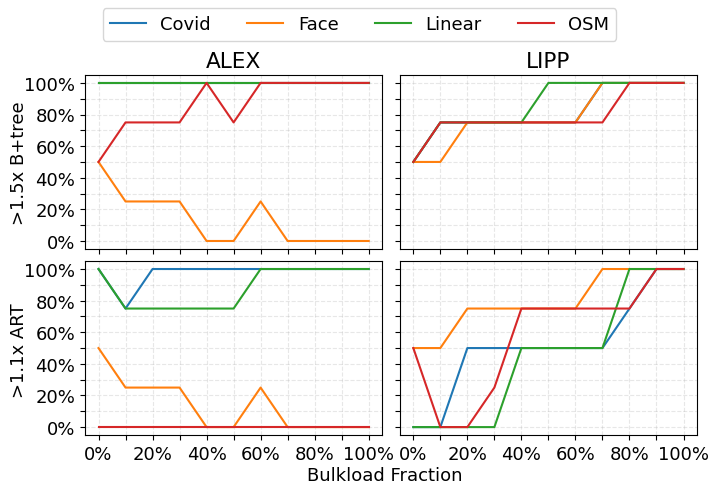

In [13]:

import matplotlib.ticker as mticker

def get_official_name(str):
    if str == "btree":
        return "B+tree"
    elif str == "btreeolc":
        return "B+tree\nOLC"
    elif str == "art":
        return "ART"
    elif str == "artolc":
        return "ART\nOLC"
    elif str == "alex":
        return "ALEX"
    elif str == "alexolc":
        return "ALEX\nOLC"
    elif str == "lipp":
        return "LIPP"
    elif str == "lippolc":
        return "LIPP\nOLC"
    elif str == "dytis":
        return "DyTIS"
    elif str == "dili":
        return "DILI"
    elif str == "finedex":
        return "FineDex"
    elif str == "sali":
        return "SALI"
    elif str == "datasets/linear":
        return "Linear"
    elif str == "datasets/covid":
        return "Covid"
    elif str == "datasets/fb":
        return "Face"
    elif str == "datasets/fb-1":
        return "Face"
    elif str == "datasets/osm":
        return "OSM"
index_types = ["btree", "art", "alex", "lipp"]
df_new = df_new[df_new["index_type"].isin(index_types)]
plt.rcParams.update({"font.size": 13})
fig, axs = plt.subplots(2, 2, figsize=(7.5,5), sharex=True, sharey=True)
for index, i in [("alex", 0), ("lipp", 1)]:
    key_paths = df_new["key_path"].unique()
    # key_paths =["datasets/covid"]
    for j, key_path in enumerate(key_paths):
        df_key_path = df_new[df_new["key_path"] == key_path]
        df_art = df_key_path[df_key_path["index_type"] == "art"]
        df_btree = df_key_path[df_key_path["index_type"] == "btree"]
        df_index = df_key_path[df_key_path["index_type"] == index]
        init_table_sizes = [0,20000000,40000000,60000000,80000000,100000000,120000000,140000000,160000000,180000000,200000000]
        init_table_sizes_str = [f"{int(size/200000000*100)}%" for size in init_table_sizes]  # 转换为字符串类别并去掉小数点
        ratios = []
        for init_table_size in init_table_sizes:
            art_mean_read_throughput = df_art["read_throughput_avg"].mean()
            btree_mean_read_throughput = df_btree["read_throughput_avg"].mean()
            df_index_init_table_size = df_index[df_index["init_table_size"] == init_table_size]
            # the ratio of how many record read_throughput_avg better than art
            if len(df_index_init_table_size) > 0:
                ratio = sum(df_index_init_table_size["read_throughput_avg"].values > 1.5*btree_mean_read_throughput) / len(df_index_init_table_size)
                ratios.append(ratio)
            else:
                ratios.append(0)
        axs[0][i].plot(init_table_sizes_str, ratios, label=get_official_name(key_path))
        
        ratios = []
        for init_table_size in init_table_sizes:
            art_mean_read_throughput = df_art["read_throughput_avg"].mean()
            btree_mean_read_throughput = df_btree["read_throughput_avg"].mean()
            df_index_init_table_size = df_index[df_index["init_table_size"] == init_table_size]
            # the ratio of how many record read_throughput_avg better than art
            if len(df_index_init_table_size) > 0:
                ratio = sum(df_index_init_table_size["read_throughput_avg"].values > 1.1*art_mean_read_throughput) / len(df_index_init_table_size)
                ratios.append(ratio)
            else:
                ratios.append(0) 
        axs[1][i].plot(init_table_sizes_str, ratios, label=get_official_name(key_path))

    # only show 0M 100M 200M
    axs[0][i].set_xticks(init_table_sizes_str[::1])
    axs[1][i].set_xticks(init_table_sizes_str[::1])
    axs[0][i].set_xticklabels(['' if j % 2 == 1 else label for j, label in enumerate(init_table_sizes_str[::1])])
    axs[1][i].set_xticklabels(['' if j % 2 == 1 else label for j, label in enumerate(init_table_sizes_str[::1])])
    axs[0][i].set_yticks(np.arange(0, 1.1, 0.1))
    axs[1][i].set_yticks(np.arange(0, 1.1, 0.1))
    axs[0][i].set_yticklabels(['' if j % 2 == 1 else f'{label*100:.0f}%' for j, label in enumerate(np.arange(0, 1.1, 0.1))])
    axs[1][i].set_yticklabels(['' if j % 2 == 1 else f'{label*100:.0f}%' for j, label in enumerate(np.arange(0, 1.1, 0.1))])
    axs[0][i].grid(True, linestyle='--', alpha=0.3)
    axs[1][i].grid(True, linestyle='--', alpha=0.3)

axs[0][0].set_title('ALEX')
axs[0][1].set_title('LIPP')
fig.text(0.04, 0.675, '>1.5x B+tree', rotation='vertical', va='center')
fig.text(0.04, 0.3, '>1.1x ART', rotation='vertical', va='center')
fig.text(0.54, 0.04, 'Bulkload Fraction', ha='center')

# Create legend with unique labels
handles, labels = fig.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

fig.legend(
    unique_labels.values(),
    unique_labels.keys(),
    loc="upper center",
    ncol=4
)
# fig.text(0.04, 0.5, 'Ratio of Read Throughput Better than Traditional Index', va='center', rotation='vertical')
plt.tight_layout(w_pad=0, h_pad=0.5)
plt.subplots_adjust(bottom=0.13)
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(left=0.14)
# plt.show()
plt.savefig("./fig/alex_lipp_read_throughput_better_than_trad.pdf",bbox_inches="tight", transparent=True)